## Library imports

In [2]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import scipy as sp
import sys
import re
from copy import deepcopy
import pickle
import random
import seaborn as sns
import gensim
import torchtext
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch import optim
torch.manual_seed(10)
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# import gzip

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

print('Version information')

print('python: {}'.format(sys.version))
print('numpy: {}'.format(np.__version__))

C:\Users\ghoneimm\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ghoneimm\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\ghoneimm\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Version information
python: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
numpy: 1.21.6


# Load Dataset


We start by loading both data sets already split into an 80/20 train and test set.

In [4]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

# Separate dataframes into train and test lists
x_train, y_train = list(df_train['headline']), list(df_train['label'])
x_test, y_test = list(df_test['headline']), list(df_test['label'])

Below is the number of headlines in the train and test set as well as a sample of the article headlines and its binary label, where 0 is considered not clickbait and 1 is clickbait.

In [5]:
print(f'Number of Train Headlines: {len(x_train)}')
print(f'Number of Test Headlines: {len(x_test)}')

print('\n\nSample Label and Headlines:')
x = 105
for label, line in zip(y_train[x:x+5], x_train[x:x+5]):
    print(f'{label}: {line}')
    
print('\nOutput of Sample Headlines without Print Statement:')
x_train[x:x+5]

Number of Train Headlines: 19200
Number of Test Headlines: 4800


Sample Label and Headlines:
1: 27 Breathtaking Alternatives To A Traditional Wedding Bouquet <br>

1: 22 Pictures People Who Aren't Grad Students Will <strong>Never</strong> Understand

0: PepsiCo Profit Falls 43 Percent

0: Website of Bill O'Reilly, FOX News commentator, hacked in retribution

1: The Green Toy Soldiers From Your Childhood Now Come In Baller Yoga Poses A


Output of Sample Headlines without Print Statement:


['27 Breathtaking Alternatives To A Traditional Wedding Bouquet <br>\n',
 "22 Pictures People Who Aren't Grad Students Will <strong>Never</strong> Understand\n",
 'PepsiCo Profit Falls 43 Percent\n',
 "Website of Bill O'Reilly, FOX News commentator, hacked in retribution\n",
 'The Green Toy Soldiers From Your Childhood Now Come In Baller Yoga Poses A\n']

In [6]:
df_train_wos = pd.read_csv('./data/train_wos.csv')
df_test_wos = pd.read_csv('./data/test_wos.csv')

# Separate dataframes into train and test lists
x_train_wos, y_train_wos = list(df_train_wos['article']), list(df_train_wos['label'])
x_test_wos, y_test_wos = list(df_test_wos['article']), list(df_test_wos['label'])

# Numerical label to domain mapping
wos_label = {0:'CS', 1:'ECE', 2:'Civil', 3:'Medical'}
# Numerical label to Numerical mapping
label_mapping = {0:0, 1:1, 4:2, 5:3}

for i, label in enumerate(y_train_wos):
    y_train_wos[i] = label_mapping[label]
for i, label in enumerate(y_test_wos):
    y_test_wos[i] = label_mapping[label]

In [7]:
print(f'Number of Train Articles: {len(x_train_wos)}')
print(f'Number of Test Articles: {len(x_test_wos)}')

print('\nLabel Key:', wos_label)

print('\nSample Label and Articles:\n')
x = 107
for label, line in zip(y_train_wos[x:x+3], x_train_wos[x:x+3]):
    print(f'{label} - {wos_label[label]}: {line}')

Number of Train Articles: 1600
Number of Test Articles: 400

Label Key: {0: 'CS', 1: 'ECE', 2: 'Civil', 3: 'Medical'}

Sample Label and Articles:

0 - CS: An efficient procedure for calculating the electromagnetic fields in multilayered cylindrical structures is reported in this paper. Using symbolic computation, spectral Green's functions, suitable for numerical implementations are determined in compact and closed forms. Applications are presented for structures with two dielectric layers.

1 - ECE: A multifunctional platform based on the microhotplate was developed for applications including a Pirani vacuum gauge, temperature, and gas sensor. It consisted of a tungsten microhotplate and an on-chip operational amplifier. The platform was fabricated in a standard complementary metal oxide semiconductor (CMOS) process. A tungsten plug in standard CMOS process was specially designed as the serpentine resistor for the microhotplate, acting as both heater and thermister. With the sacrifici

Here, we use truncated SVD to project the learned word2vec embedding to 2D space for visualization.

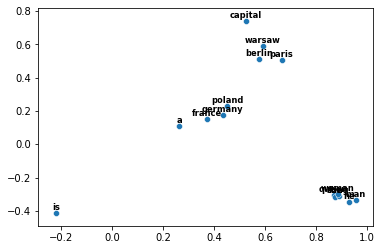

In [80]:


from sklearn import decomposition

w2v.word2idx[''] = 0
svd = decomposition.TruncatedSVD(n_components=2)
W2_dec = svd.fit_transform(embeddings)

x = W2_dec[:,0]
y = W2_dec[:,1]
plot = sns.scatterplot(x=x, y=y)

for i in range(0,W2_dec.shape[0]):
     plot.text(x[i], y[i]+2e-2, list(w2v.word2idx)[i], horizontalalignment='center', size='small', color='black', weight='semibold');

Here, we will look into the learned property of the word2vec embedding. Warsaw is the capital of Poland and we now calculate the difference between embeddings of "warsaw" and "poland". After that, we add the difference to the embedding of "paris". We then rank the dot product of the computed embedding vs all the embeddings. Notice that the larger this value, the more similar two embeddings are.

In [81]:
emb1 = embeddings[w2v.word2idx["poland"]]
emb2 = embeddings[w2v.word2idx["warsaw"]]
emb3 = embeddings[w2v.word2idx["paris"]]

emb4 = emb1 - emb2 + emb3
emb4_norm = (emb4 ** 2).sum() ** (1 / 2)
emb4 = emb4 / emb4_norm

emb4 = np.reshape(emb4, (len(emb4), 1))
dists = np.matmul(embeddings_norm, emb4).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print("{}: {:.3f}".format(w2v.idx2word[word_id], dists[word_id]))

poland: 0.682
paris: 0.535
germany: 0.404
france: 0.353
woman: 0.275


Ideally with large amount of data, we should have got france as the most nearest word. But depending on the implementation and amount of data, it can vary.

## Classification with CNN

Convolutional layers are used to find patterns by sliding small kernel window over input. Instead of multiplying the filters on the small regions of the images, it slides through embedding vectors of few words as mentioned by window size. For looking at sequences of word embeddings, the window has to look at multiple word embeddings in a sequence. They will be rectangular with size window_size * embedding_size. For example, if window size is 3 then kernel will be 3*500. This essentially represents n-grams in the model. The kernel weights (filter) are multiplied to word embeddings in pairs and summed up to get output values. As the network is being learned, these kernel weights are also being learned.

We will be using convolutional network with pre-trained word2vec models for classification. We implement a convolutional neural network for text classification similar to the CNN-rand baseline described by [Kim (2014)](https://aclanthology.org/D14-1181.pdf). We use pre-trained word2vec models for feasibility of finding appropriate embeddings. The architecture of our model looks like :

<p align="center"><img src="https://cezannec.github.io/assets/cnn_text/complete_text_classification_CNN.png" width="75%" align="center"></p>

We will be using an Embedding layer loaded with a word2vec model, followed by a convolution layer, and a linear layer.

We will would be using the Clickbait and Web of science dataset for this task.

### 2.1.1 : Pre-Processing Data


In [93]:
from gensim.utils import simple_preprocess

def preprocess(data):
    preprocessed_data = []
    for text in data:
        tokens = simple_preprocess(text, deacc=True)
        preprocessed_data.append(tokens)
    return preprocessed_data

preprocessed_x_train = preprocess(x_train)
preprocessed_x_train_wos = preprocess(x_train_wos)

preprocessed_x_test = preprocess(x_test)
preprocessed_x_test_wos = preprocess(x_test_wos)

In [94]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


### 2.1.2 : Utility functions for training Word2Vec Model

Run the below cells for making word2vec model, vectors and target.

In [95]:


from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec

porter_stemmer = PorterStemmer()

size = 500
window = 3
min_count = 1
workers = 3
sg = 1

# Function to train word2vec model
def make_word2vec_model(data, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    data.append(['pad'])
    w2v_model = Word2Vec(data, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
    return w2v_model

In [96]:


def make_word2vec_vector(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [97]:


def make_target(label):
  return torch.tensor([label], dtype=torch.long, device=device)

## 2.2 : Classifying Clickbait Dataset using CNN

Run the below cell to classify the Clickbait train and test dataset using the CNN functions already implemented in 2.

An accuracy of more than 80% is acceptable.


In [98]:
# Train Word2vec model
w2vmodel = make_word2vec_model(preprocessed_x_train, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

In [99]:
w2vmodel.wv['pad']

array([ 0.0517495 ,  0.02628629,  0.07220484, -0.03108063, -0.02587266,
       -0.0301182 , -0.06114997, -0.02721459, -0.02983144,  0.05376582,
        0.06676152, -0.0726303 ,  0.02780348, -0.03402811, -0.03466607,
        0.01522685,  0.0019432 , -0.0558793 ,  0.03599539,  0.0414186 ,
        0.04959976, -0.02714492,  0.05093278, -0.00703063, -0.01265506,
       -0.05490255, -0.00043444,  0.03858402,  0.02700144,  0.02332128,
        0.05327508, -0.03958281, -0.0066215 ,  0.00677643,  0.00272754,
       -0.00031868,  0.00169334, -0.03721954, -0.05408469, -0.03118667,
        0.00797785,  0.01963314, -0.00513649,  0.00493522, -0.04443372,
       -0.00914803, -0.00841375, -0.00455312,  0.05230442,  0.03279027,
       -0.00030661,  0.0113712 , -0.01001645, -0.02666881, -0.01318737,
        0.01622818,  0.01851158,  0.00201129,  0.00134771,  0.00694489,
       -0.01407568,  0.04534241, -0.02779939,  0.03252061, -0.0530932 ,
       -0.04275605, -0.01937444,  0.02310384,  0.03537126, -0.04

Because CNN requires the input data to be of the same length. We use the embedding of the "pad" word as the padding vector. Notice that this choice is just a convention and other tokens could also work for this purpose. In more complex language model, there will be a dedicated '\<pad\>' token for padding.

In [100]:
max_sen_len = max(map(len, preprocessed_x_train))
padding_idx = w2vmodel.wv.vocab['pad'].index

In [101]:
padding_idx

3060

In [102]:
torch.from_numpy(w2vmodel.wv.vectors).type(torch.float32).unsqueeze(1).squeeze(0).shape

torch.Size([17099, 1, 500])

In [122]:
from cnn import CNN

NUM_CLASSES = 2

model = CNN(w2vmodel, num_classes=NUM_CLASSES)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
N_EPOCHS = 5

model.train()
for epoch in range(N_EPOCHS):
    total_loss = 0.0
    shuffled_i = list(range(0,len(y_train)))
    random.shuffle(shuffled_i)
    print(epoch)
    for index in range(len(shuffled_i)):
        model.zero_grad()
        bow_vec = make_word2vec_vector(preprocessed_x_train[index])

        outputs = model(bow_vec)
        y = make_target(y_train[index])

        loss = criterion(outputs, y)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()


    print("loss on epoch %i: %f" % (epoch, total_loss))

0
loss on epoch 0: 7294.662585
1
loss on epoch 1: 7120.011679
2
loss on epoch 2: 7078.914021
3
loss on epoch 3: 7043.359826
4
loss on epoch 4: 7016.684704


In [123]:
from sklearn.metrics import accuracy_score
cnn_predictions = []
original_lables_cnn = []
model.eval()

with torch.no_grad():
    for index in range(len(y_test)):
        bow_vec = make_word2vec_vector(preprocessed_x_test[index])
        probs = model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        cnn_predictions.append(predicted.cpu().numpy()[0])
        t = make_target(y_test[index]).cpu().numpy()[0]
        original_lables_cnn.append(make_target(y_test[index]).cpu().numpy()[0])

print("Test Accuracy on Clickbait Dataset using CNN : {:.3f}".format(accuracy_score(original_lables_cnn, cnn_predictions)))

Test Accuracy on Clickbait Dataset using CNN : 0.942


In [124]:

preds = np.asarray(cnn_predictions)

with open('cnn_clickbait.pkl', 'wb') as fp:
    pickle.dump(preds, fp)

## 2.3 : Classifying Web of Science Dataset using CNN

Run the below cell to classify the WoS train and test dataset using the CNN functions implemented in 2.


In [125]:
# Train Word2vec model
w2vmodel = make_word2vec_model(preprocessed_x_train_wos, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

In [126]:
max_sen_len = max(map(len, preprocessed_x_train_wos))
padding_idx = w2vmodel.wv.vocab['pad'].index

In [128]:
from cnn import CNN

NUM_CLASSES = 4

model = CNN(w2vmodel, num_classes=NUM_CLASSES)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
N_EPOCHS = 20

model.train()
for epoch in range(N_EPOCHS):
    total_loss = 0.0
    shuffled_i = list(range(0,len(y_train_wos)))
    random.shuffle(shuffled_i)
    print(epoch)
    for index in range(len(shuffled_i)):
        model.zero_grad()
        bow_vec = make_word2vec_vector(preprocessed_x_train_wos[index])
        outputs = model(bow_vec)
        y = make_target(y_train_wos[index])

        loss = criterion(outputs, y)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()


    if epoch % 5 == 0:    
      print("loss on epoch %i: %f" % (epoch, total_loss))

0
loss on epoch 0: 1960.494195
1
2
3
4
5
loss on epoch 5: 1588.307115
6
7
8
9
10
loss on epoch 10: 1498.507259
11
12
13
14
15
loss on epoch 15: 1449.376294
16
17
18
19


In [129]:
from sklearn.metrics import accuracy_score
cnn_predictions = []
original_lables_cnn = []
model.eval()

with torch.no_grad():
    for index in range(len(y_test_wos)):
        bow_vec = make_word2vec_vector(preprocessed_x_test_wos[index])
        probs = model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        cnn_predictions.append(predicted.cpu().numpy()[0])
        t = make_target(y_test_wos[index]).cpu().numpy()[0]
        original_lables_cnn.append(make_target(y_test_wos[index]).cpu().numpy()[0])

print("Test Accuracy on WoS Dataset using CNN : {:.3f}".format(accuracy_score(original_lables_cnn, cnn_predictions)))

Test Accuracy on WoS Dataset using CNN : 0.635


Run the below cell to save the predictions. You will be required to upload the predictions on gradescope for evaluation.

In [130]:
preds = np.asarray(cnn_predictions)

with open('cnn_wos.pkl', 'wb') as fp:
    pickle.dump(preds, fp)

## Classification with RNN


We will be using recurrent neural networks with pre-trained word2vec models for classification. We use pre-trained word2vec models for feasibility of finding appropriate embeddings. The architecture of our model looks like :

<p align="center"><img src="https://www.tensorflow.org/static/text/tutorials/images/bidirectional.png" width="75%" align="center"></p>

We will be using an Embedding layer loaded, followed by a RNN layer, and a linear layer.

We will would be using the Clickbait and Web of science dataset for this task.

### 3.1.1 : Pre-Processing Data 

load functions for building vocabulary and tokenizing the sentences.

In [157]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
  for dataset in datasets:
    for text in dataset:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([x_train]), min_freq=1, specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

vocab_wos = build_vocab_from_iterator(build_vocabulary([x_train_wos]), min_freq=1, specials=["<UNK>"])
vocab_wos.set_default_index(vocab["<UNK>"])

## 3.2 : Classifying Clickbait Dataset using RNN

classify the Clickbait train and test dataset using the RNN functions that you have already implemented in 3.

An accuracy of more than 85% is acceptable.


In [158]:
from torch.utils.data import DataLoader

max_words = max(map(len, x_train))

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X] ## Tokenize and map tokens to indexes
    X_len = [len(text) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
    return torch.tensor(X, dtype=torch.int32), torch.tensor(X_len), torch.tensor(Y)

In [159]:
train_dataset = list(map(lambda y, x: (y, x), y_train, x_train))
test_dataset = list(map(lambda y, x: (y, x), y_test, x_test))

train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1024, collate_fn=vectorize_batch)

In [162]:
len(vocab)

18559

In [176]:
from rnn import RNN
from tqdm import tqdm

NUM_CLASSES = 2

model = RNN(vocab, num_classes=NUM_CLASSES)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
N_EPOCHS = 5

model.train()
for epoch in range(N_EPOCHS):
    total_loss = 0.0
    for X, X_len, Y in tqdm(train_loader):
      X = X.to(device)
      Y = Y.to(device)
    
      outputs = model(X, X_len)
      loss = criterion(outputs, Y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print("loss on epoch %i: %f" % (epoch, total_loss))

[autoreload of rnn failed: Traceback (most recent call last):
  File "C:\Users\ghoneimm\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\ghoneimm\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\ghoneimm\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "C:\Users\ghoneimm\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "C:\Users\ghoneimm\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "C:\Users\ghoneimm\AppData\Local\Continuum\anaconda3\l

loss on epoch 0: 7.642385


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

loss on epoch 1: 2.991242


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

loss on epoch 2: 1.574596


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

loss on epoch 3: 0.988239


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.56it/s]

loss on epoch 4: 0.693172


In [177]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
  Y_truth, Y_preds = [],[]
  for X, X_len, Y in test_loader:
    X = X.to(device)
    outputs = model(X, X_len)

    Y_truth.append(Y)
    Y_preds.append(outputs)

  Y_truth = torch.cat(Y_truth)
  Y_preds = torch.cat(Y_preds)

print("Test Accuracy on Clickbait Dataset using RNN  : {:.3f}".format(accuracy_score(Y_truth.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy())))

Test Accuracy on Clickbait Dataset using RNN  : 0.932


Run the below cell to save the predictions. You will be required to upload the predictions on gradescope for evaluation.

In [178]:
preds = F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

with open('rnn_clickbait.pkl', 'wb') as fp:
    pickle.dump(preds, fp)

## 3.3 : Classifying Web of Science Dataset using RNN

classify the WoS train and test dataset using the lstm functions implemented in 3.

An accuracy of more than 35% is acceptable.

In [179]:
max_words = max(map(len, x_train_wos))

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab_wos(tokenizer(text)) for text in X] ## Tokenize and map tokens to indexes
    X_len = [len(text) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] 
    return torch.tensor(X, dtype=torch.int32), torch.tensor(X_len), torch.tensor(Y)

In [180]:
train_dataset = list(map(lambda y, x: (y, x), y_train_wos, x_train_wos))
test_dataset = list(map(lambda y, x: (y, x), y_test_wos, x_test_wos))

train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, collate_fn=vectorize_batch)

In [182]:
from rnn import RNN
from tqdm import tqdm

NUM_CLASSES = 4

model = RNN(vocab_wos, num_classes=NUM_CLASSES)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
N_EPOCHS = 20

model.train()
for epoch in range(N_EPOCHS):
    total_loss = 0.0
    for X, X_len, Y in tqdm(train_loader):
      X = X.to(device)
      Y = Y.to(device)
      outputs = model(X, X_len)
      loss = criterion(outputs, Y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print("loss on epoch %i: %f" % (epoch, total_loss))

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 0: 17.465020


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 1: 15.911758


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 2: 15.190116


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 3: 14.551816


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 4: 13.835879


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 5: 12.974420


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 6: 12.280683


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 7: 11.578939


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 8: 10.312908


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 9: 9.603132


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 10: 8.815215


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 11: 7.935928


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 12: 7.399226


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 13: 6.557069


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 14: 5.626970


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 15: 5.244434


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 16: 4.670967


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 17: 4.142456


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

loss on epoch 18: 3.407744


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:58<00:00, 13.69s/it]

loss on epoch 19: 3.297573


In [183]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
  Y_truth, Y_preds = [],[]
  for X, X_len, Y in test_loader:
    X = X.to(device)
    outputs = model(X, X_len)

    Y_truth.append(Y)
    Y_preds.append(outputs)

  Y_truth = torch.cat(Y_truth)
  Y_preds = torch.cat(Y_preds)

print("Test Accuracy on WoS Dataset using RNN  : {:.3f}".format(accuracy_score(Y_truth.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy())))

Test Accuracy on WoS Dataset using RNN  : 0.427


In [184]:
preds = F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

with open('rnn_wos.pkl', 'wb') as fp:
    pickle.dump(preds, fp)